## Dependencies

In [ ]:
!pip install yfinance

In [ ]:
import yfinance as yf
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import norm
from numpy.polynomial.polynomial import Polynomial

## Import Data from Yahoo Finance

In [ ]:
def get_stock_prices(stock_symbol, start_date='2023-01-01', end_date='2023-12-31'):
    stock_data = yf.download(stock_symbol, start=start_date, end=end_date)
    closing_prices = stock_data['Adj Close']
    return closing_prices.iloc[-1]  # Return the last closing price

## Models

### Binomial Model

In [ ]:
def binomial_model_american_option(S0, K, T, r, sigma, N, option_type='call'):
    """
    S0: initial stock price
    K: strike price
    T: time to maturity (in years)
    r: risk-free rate
    sigma: volatility
    N: number of steps in the binomial tree
    option_type: 'call' or 'put'
    """
    dt = T / N  # Time step
    u = np.exp(sigma * np.sqrt(dt))  # Upward movement factor
    d = 1 / u  # Downward movement factor
    p = (np.exp(r * dt) - d) / (u - d)  # Risk-neutral probability

    # Initialize asset prices at maturity
    ST = S0 * d**np.arange(N, -N-1, -2) * u**np.arange(0, 2*N+1, 2)

    # Initialize option values at maturity
    if option_type == 'call':
        option_values = np.maximum(ST - K, 0)
    else:  # put
        option_values = np.maximum(K - ST, 0)

    # Iterate backwards through the tree
    for i in range(N, 0, -1):
        option_values = 0.5 * p * option_values[1:] + 0.5 * (1 - p) * option_values[:-1]
        ST = S0 * d**np.arange(i-1, -i, -2) * u**np.arange(0, 2*(i-1)+1, 2)  # Recalculate ST for early exercise check
        if option_type == 'call':
            early_exercise_value = np.maximum(ST - K, 0)
        else:
            early_exercise_value = np.maximum(K - ST, 0)
        option_values = np.maximum(option_values, early_exercise_value)  # Check for early exercise

    return option_values[0]


### Monte Carlo Model

#### Simulate Stock Price Paths

In [ ]:
def simulate_stock_price(S0, r, sigma, T, N, M):
    """
    S0: Initial stock price
    r: Risk-free rate
    sigma: Volatility
    T: Time to maturity
    N: Number of time steps
    M: Number of paths
    """
    dt = T / N
    S = np.zeros((N+1, M))
    S[0] = S0
    for t in range(1, N+1):
        Z = np.random.standard_normal(M)  # Random variables
        S[t] = S[t-1] * np.exp((r - 0.5 * sigma**2) * dt + sigma * np.sqrt(dt) * Z)
    return S

#### Least Squares Monte Carlo for American Option Pricing

In [ ]:
def LSMC(S, K, r, T, N):
    """
    S: Simulated stock paths
    K: Strike price
    r: Risk-free rate
    T: Time to maturity
    N: Number of time steps
    """
    M = S.shape[1]
    dt = T / N
    payoff = np.maximum(S[-1] - K, 0)  # Payoff at maturity for a call option
    for t in range(N-1, 0, -1):
        itm = np.where(S[t] > K)[0]  # In-the-money paths
        if len(itm) > 0:
            X = S[t, itm]
            Y = np.exp(-r * dt) * payoff[itm]
            # Least squares regression to estimate continuation value
            p = np.polyfit(X, Y, 2)
            C = np.polyval(p, X)
            # Exercise decision
            exercise = np.where(np.maximum(S[t, itm] - K, 0) > C)[0]
            payoff[itm[exercise]] = np.maximum(S[t, itm[exercise]] - K, 0)
        payoff = np.exp(-r * dt) * payoff  # Discount back to previous time step
    option_price = np.mean(payoff)  # Average the discounted payoff
    return option_price

## Results

In [ ]:
# Parameters
S0 = get_stock_prices('AAPL')  # Fetch the last closing price of AAPL
K = 210  # Example strike price
T = 1  # Time to maturity in years
r = 0.01  # Risk-free rate (annual)
sigma = 0.2  # Volatility (annual)
N = 100  # Number of steps in the binomial tree

# Calculate option price
option_price = binomial_model_american_option(S0, K, T, r, sigma, N, option_type='call')
print()
print(f"American Call Option Price: {option_price}")


[*********************100%%**********************]  1 of 1 completed


American Call Option Price: 0.6164091240017081


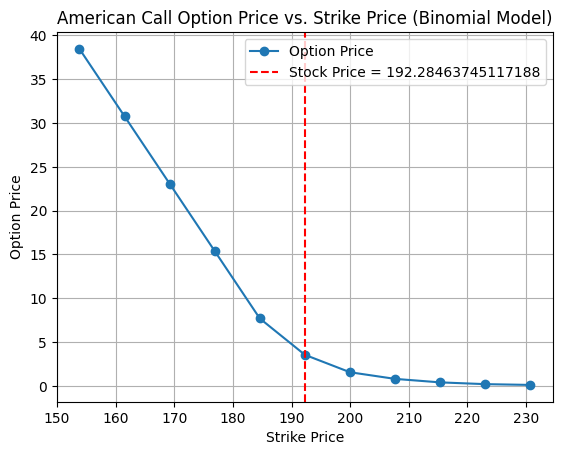

In [ ]:
strike_prices = np.linspace(0.8 * S0, 1.2 * S0, 11)
option_prices = [binomial_model_american_option(S0, K, T, r, sigma, N, option_type='call') for K in strike_prices]

plt.plot(strike_prices, option_prices, '-o', label='Option Price')
plt.axvline(x=S0, color='r', linestyle='--', label=f'Stock Price = {S0}')
plt.title('American Call Option Price vs. Strike Price (Binomial Model)')
plt.xlabel('Strike Price')
plt.ylabel('Option Price')
plt.legend()
plt.grid(True)
plt.show()

In [ ]:
# Fetch the real stock price for AAPL
S0_real = get_stock_prices('AAPL')
print(f"Real Stock Price (AAPL): {S0_real}")

# Parameters using real stock data
S0 = S0_real  # Real initial stock price from AAPL
r = 0.05  # Approximate risk-free rate
sigma = 0.2  # Approximate volatility (Consider fetching historical volatility)
T = 1  # Time to maturity (1 year)
N = 50  # Number of time steps
M = 10000  # Number of simulated paths

# Simulate stock price paths with real data
S = simulate_stock_price(S0, r, sigma, T, N, M)

# Execute LSMC for an American call option with a range of strike prices
strike_prices = np.linspace(0.8 * S0, 1.2 * S0, 11)
option_prices = [LSMC(S, K, r, T, N) for K in strike_prices]

# Print the American call option price for a specific strike price
# Assuming you want to see the option price for a strike price close to S0
specific_strike_price = S0  # For example, using the real stock price as the strike price
specific_option_price = LSMC(S, specific_strike_price, r, T, N)
print(f"American Call Option Price for Strike Price {specific_strike_price}: {specific_option_price:.2f}")


[*********************100%%**********************]  1 of 1 completed


Real Stock Price (AAPL): 192.28463745117188
American Call Option Price for Strike Price 192.28463745117188: 20.16


<ipython-input-13-34974ce71665>:18: RankWarning: Polyfit may be poorly conditioned
  p = np.polyfit(X, Y, 2)


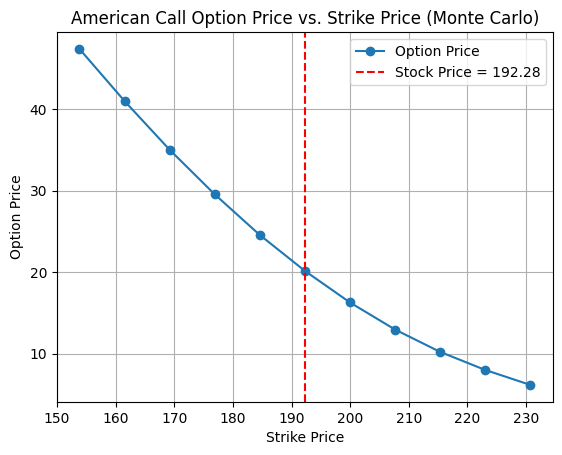

In [ ]:

# Plot the option prices against strike prices
plt.plot(strike_prices, option_prices, '-o', label='Option Price')
plt.axvline(x=S0, color='r', linestyle='--', label=f'Stock Price = {S0:.2f}')
plt.title('American Call Option Price vs. Strike Price (Monte Carlo)')
plt.xlabel('Strike Price')
plt.ylabel('Option Price')
plt.legend()
plt.grid(True)
plt.show()